# Adding Hydrogens

To find hydrogen bonds between ligands and proteins, both the protein and the ligand must have hydrogens.

In this notebook we explore different ways of adding hydrogens

In [1]:
import mdtraj as mdt
import nglview as nv
import numpy as np
import openpharmacophore
from openmm.app import Modeller, PDBFile
from pdbfixer import PDBFixer
import pyunitwizard as puw
from rdkit import Chem

import pl_interactions as pli
import view_feats

from pprint import pprint

In [2]:
pdb_path = "./data/3bbh/3bbh_A_chain.pdb"

In [3]:
# Count hydrogens in original file
traj = mdt.load(pdb_path)
n_hydrogens = len([a for a in traj.topology.atoms if a.element.symbol == "H"])
print(f"Traj contains {n_hydrogens} hydrogens")

Traj contains 0 hydrogens


## Adding H's with PDBFixer

In [4]:
fixer = PDBFixer(pdb_path)
fixer.addMissingHydrogens()
PDBFile.writeFile(fixer.topology, 
                  fixer.positions, 
                  open("./data/3bbh/3bbh_A_hyd.pdb", "w"))

In [5]:
traj = mdt.load("./data/3bbh/3bbh_A_hyd.pdb")
n_hydrogens = len([a for a in traj.topology.atoms if a.element.symbol == "H"])
print(f"Traj contains {n_hydrogens} hydrogens")

Traj contains 1780 hydrogens


In [6]:
pli.find_ligands_in_traj(traj)

['SFG:B']

In [7]:
lig_indices = [a.index for a in traj.topology.atoms if a.residue.name == "SFG"]
n_hydrogens = len([
    a for a in lig_indices if traj.topology.atom(a).element.symbol == "H"])
print(f"Ligand contains {n_hydrogens} hydrogens")

Ligand contains 0 hydrogens


In [8]:
view = nv.show_mdtraj(traj)
view.representations = [
     {"type": "ball+stick", 
      "params": {
          "sele": "protein",
      }}
]

view

NGLWidget()

## Adding hydrogens to the ligand

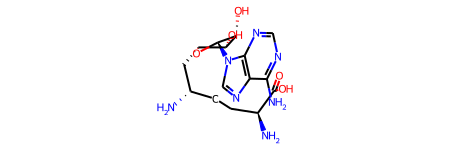

In [9]:
supplier = Chem.SDMolSupplier("./data/3bbh/sfg.sdf")
ligand = next(supplier)
ligand

In [10]:
ligand_hyd = Chem.AddHs(ligand, addCoords=True)
nv.show_rdkit(ligand_hyd)

NGLWidget()

In [11]:
n_hydrogens = len([a for a in ligand_hyd.GetAtoms() if a.GetSymbol() == "H"])
print(f"Ligand contains {n_hydrogens} hydrogens")

Ligand contains 23 hydrogens


In [12]:
# Compare chemical features of ligand with hydrogens and ligand with no hydrogens
feats_no_hyd = pli.chemical_features(ligand, pli.smarts_feat_def)
pprint(feats_no_hyd)

defaultdict(<class 'list'>,
            {'Acceptor': [(0,),
                          (8,),
                          (19,),
                          (23,),
                          (25,),
                          (3,),
                          (4,),
                          (11,),
                          (13,),
                          (15,)],
             'Aromatic': [(17, 18, 19, 20, 26), (20, 21, 23, 24, 25, 26)],
             'Donor': [(0,), (8,), (22,), (13,), (15,)],
             'NegIonizable': [(2, 3, 4)]})


In [13]:
feats_hyd = pli.chemical_features(ligand_hyd, pli.smarts_feat_def)
pprint(feats_hyd)

defaultdict(<class 'list'>,
            {'Acceptor': [(0,),
                          (8,),
                          (19,),
                          (23,),
                          (25,),
                          (3,),
                          (4,),
                          (11,),
                          (13,),
                          (15,)],
             'Aromatic': [(17, 18, 19, 20, 26), (20, 21, 23, 24, 25, 26)],
             'Donor': [(0,), (8,), (22,), (13,), (15,)],
             'NegIonizable': [(2, 3, 4)],
             'PosIonizable': [(0,), (8,)]})


## Finding hydrogen bonds between protein and ligand

### Baker-Hubbard Criterion
We proceed to find hydrogen bonds between protein and ligand using Baker-Hubbard criterion.

In [14]:
hbonds_bh = mdt.baker_hubbard(traj)
print(f"{hbonds_bh.shape[0]} hydrogen bonds")

104 hydrogen bonds


In [15]:
def protein_ligand_hbonds(hbonds, lig_indices):
    """ Returns the hbonds between the protein and the ligand.
    """
    prot_lig_hb = []
    for bond in hbonds:
        for index in bond:
            if index in lig_indices:
                prot_lig_hb.append(bond.tolist())
                break

    print(f"{len(prot_lig_hb)} hydrogen bonds between protein and ligand")
    
    return prot_lig_hb

In [16]:
prot_lig_bh = protein_ligand_hbonds(hbonds_bh, lig_indices)

3 hydrogen bonds between protein and ligand


To visualize the hydrogen bonds, we'll create a new trajectory that contains the resiudes that participate in hydrogen bonding
and the ligand

In [17]:
def hbonding_traj(traj, hbonds):
    """ Returns a new trajectory with resiudes involved in hydrogen bonding.
    """
    indices = set()
    topology = traj.topology
    
    # Find the indices of the resiudes
    for bond in hbonds:
        don_idx, hyd_idx, acc_idx = bond
        
        don_residue = topology.atom(don_idx).residue.index
        for atom in topology.residue(don_residue).atoms:
            indices.add(atom.index)
        
        acc_residue = topology.atom(acc_idx).residue.index
        for atom in topology.residue(acc_residue).atoms:
            indices.add(atom.index)

    indices_list = list(indices)
    indices_list.sort()
    return indices_list
        

In [18]:
hbonds_indx_bh = hbonding_traj(traj, prot_lig_bh)
hbond_traj_bh = traj.atom_slice(hbonds_indx_bh)
print(hbond_traj_bh)

<mdtraj.Trajectory with 1 frames, 72 atoms, 4 residues, and unitcells>


In [19]:
def add_hbond_to_view(view, traj, hbonds):
    """ Add hydrogen bonds to a view.
        
        Parameters
        ----------
        traj : mdtraj.Trajectory
        hbonds : list[list[int]]
    """
    for ii, bond in enumerate(hbonds):
        # Indices of the atoms
        don_idx, hyd_idx, acc_idx = bond
        donor = traj.xyz[0, don_idx, :] * 10  # convert to angstroms 
        acceptor = traj.xyz[0, acc_idx, :] * 10
        
        direction = acceptor - donor
        direction /= np.linalg.norm(direction)
        
        view_feats.add_sphere_to_view(
            view, donor, 1.0, view_feats.palette["Donor"], 
            "Donor" +  " " + str(ii)
        )
        view_feats.add_sphere_to_view(
            view, acceptor, 1.0, view_feats.palette["Acceptor"], 
            "Acceptor" + " " + str(ii)
        )
        
        
        end_arrow = ((donor + direction))
        view_feats.add_arrow_to_view(view, donor, 
                                     end_arrow, view_feats.palette["Donor"])
        

In [20]:
hbond_view = nv.show_mdtraj(hbond_traj_bh)
hbond_view.add_component(ligand_hyd)
hbond_view.representations = [
     {"type": "ball+stick", 
      "params": {
          "sele": "all",
      }}
]
add_hbond_to_view(hbond_view, traj, prot_lig_bh)
hbond_view

NGLWidget()

<strong>Note:</strong> We only find acceptors in the ligand because the ligand in the trajectory does not contain hydrogens.
The hydrogens in the ligand are shown in the view because it was added as another component from an independent molecule.

### Wernet Nilson Criterion

In [21]:
hbonds_wn = mdt.wernet_nilsson(traj)[0]
print(f"{hbonds_wn.shape[0]} hydrogen bonds")

37 hydrogen bonds


In [22]:
prot_lig_wn = protein_ligand_hbonds(hbonds_wn, lig_indices)

0 hydrogen bonds between protein and ligand


## Adding H's with rdkit

In [23]:
mol = Chem.MolFromPDBFile(pdb_path)
n_hydrogens = len([a for a in mol.GetAtoms() if a.GetSymbol() == "H"])
print(f"Molecule contains {n_hydrogens} hydrogens")

Molecule contains 0 hydrogens


In [24]:
mol = Chem.AddHs(mol, addCoords=True, addResidueInfo=True)
n_hydrogens = len([a for a in mol.GetAtoms() if a.GetSymbol() == "H"])
print(f"Molecule contains {n_hydrogens} hydrogens")

Molecule contains 1802 hydrogens


In [25]:
view = nv.show_rdkit(mol)
view.representations = [
     {"type": "ball+stick", 
      "params": {
          "sele": "all",
      }},
]

view

NGLWidget()

## Create Mdtraj trajectory with hydrogens

We create a trajectory where the protein and the ligand have hydrogens and the bond order in the ligand is correct. 
First, we remove the ligand from the original pdb.

Having the ligand and the protein with hydrogens we should be able to find all hydrogen bonds between the protein and the ligand. This means that we can find acceptors and donors in the ligand

### Adding hydrogens to protein with Openmm

In [26]:
# The ligand does not contain hydrogens
traj = mdt.load(pdb_path)
n_hydrogens = len([a for a in traj.topology.atoms if a.element.symbol == "H"])
print(f"Traj contains {n_hydrogens} hydrogens")
print(f"Traj has {traj.n_atoms} atoms")

Traj contains 0 hydrogens
Traj has 1713 atoms


In [27]:
pli.find_ligands_in_traj(traj)

['SFG:B']

In [28]:
def remove_ligand(traj, lig_id):
    lig_name = lig_id.split(":")[0]
    atoms = [
        a.index for a in traj.topology.atoms if a.residue.name != lig_name
    ]
    return traj.atom_slice(atoms)

In [29]:
traj = remove_ligand(traj, "SFG:B")
print(f"Traj has {traj.n_atoms} atoms")

Traj has 1686 atoms


In [30]:
modeller = Modeller(
    topology=traj.topology.to_openmm(),
    positions=traj.openmm_positions(0)
)
modeller.addHydrogens()
n_atoms = modeller.getTopology().getNumAtoms()
print(f"Num atoms {n_atoms}")

Num atoms 3466


In [31]:
def modeller_to_trajectory(modeller):
    """ Convert an openmm.Modeller to a mdtraj.Trajectory.

        Parameters
        ----------
        modeller : openmm.Modeller

        Returns
        -------
        mdtraj.Trajectory
    """
    positions = modeller.getPositions()
    n_atoms = len(positions)
    coords = np.zeros((1, n_atoms, 3))

    for jj in range(n_atoms):
        coords[0, jj, :] = puw.get_value(
            positions[jj], to_unit="nanometers")

    topology = mdt.Topology.from_openmm(modeller.getTopology())
    return mdt.Trajectory(coords, topology)

In [32]:
traj = modeller_to_trajectory(modeller)
n_hydrogens = len([a for a in traj.topology.atoms if a.element.symbol == "H"])
print(f"Traj contains {n_hydrogens} hydrogens")
print(f"Traj has {traj.n_atoms} atoms")

Traj contains 1780 hydrogens
Traj has 3466 atoms


### Loading ligand

In [33]:
Chem.MolToPDBFile(ligand_hyd, "./data/3bbh/sgf.pdb")

In [34]:
ligand_traj = mdt.load("./data/3bbh/sgf.pdb")
n_hydrogens = len([a for a in ligand_traj.topology.atoms if a.element.symbol == "H"])
print(f"Traj contains {n_hydrogens} hydrogens")

Traj contains 23 hydrogens


In [35]:
nv.show_mdtraj(ligand_traj)

NGLWidget()

### Concatenation of trajectories

In [36]:
# Concatenate coordinates
coords = np.concatenate((traj.xyz, ligand_traj.xyz), axis=1)
print(coords.shape)

(1, 3516, 3)


In [37]:
# Concatenate topologies
topology = traj.topology.join(ligand_traj.topology)

In [38]:
traj = mdt.Trajectory(coords, topology)
traj

<mdtraj.Trajectory with 1 frames, 3516 atoms, 205 residues, without unitcells at 0x7fae0002dfd0>

In [39]:
view = nv.show_mdtraj(traj)
view

NGLWidget()

In [40]:
traj.save_pdb("./data/3bbh/3bbh_hyd.pdb")

In [41]:
view._ngl_component_names

['nglview.adaptor.MDTrajTrajectory']

In [42]:
traj_df, _ = traj.topology.to_dataframe()

In [43]:
traj_df["resName"].unique()

array(['THR', 'TYR', 'ASN', 'ILE', 'LEU', 'ALA', 'LYS', 'SER', 'GLU',
       'PRO', 'ARG', 'VAL', 'ASP', 'HIS', 'MET', 'GLY', 'PHE', 'TRP',
       'CYS', 'UNL'], dtype=object)

In [44]:
lig_indices = [a.index for a in traj.topology.atoms if a.residue.name == "UNL"]
n_hydrogens = len([
    a for a in lig_indices if traj.topology.atom(a).element.symbol == "H"])
print(f"Ligand contains {n_hydrogens} hydrogens")

Ligand contains 23 hydrogens


In [45]:
hbonds_bh = mdt.baker_hubbard(traj)
print(f"{hbonds_bh.shape[0]} hydrogen bonds")

116 hydrogen bonds


In [46]:
prot_lig_bh = protein_ligand_hbonds(hbonds_bh, lig_indices)

7 hydrogen bonds between protein and ligand


In [47]:
hbonds_indx_bh = hbonding_traj(traj, prot_lig_bh)
hbond_traj_bh = traj.atom_slice(hbonds_indx_bh)
print(hbond_traj_bh)

<mdtraj.Trajectory with 1 frames, 180 atoms, 8 residues, without unitcells>


In [48]:
hbond_view = nv.show_mdtraj(hbond_traj_bh)
# hbond_view.add_component(ligand_hyd)
hbond_view.representations = [
     {"type": "ball+stick", 
      "params": {
          "sele": "protein",
          # "color": "residueindex"
      }},
    {"type": "ball+stick", 
     "params": {
         "sele": "( not polymer or hetero ) and not ( water or ion )"
    }}
]
add_hbond_to_view(hbond_view, traj, prot_lig_bh)
hbond_view

NGLWidget()

In [49]:
hbond_view.representations

[{'type': 'ball+stick', 'params': {'sele': 'protein'}},
 {'type': 'ball+stick',
  'params': {'sele': '( not polymer or hetero ) and not ( water or ion )'}}]

In [50]:
hbond_view._ngl_component_names

['nglview.adaptor.MDTrajTrajectory',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape',
 'nglview.shape.Shape']